In [12]:
import sys, os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import smc_samplers as smp
from particles import kalman
from particles import resampling
from particles import mcmc
from particles import rao_blackwell
from particles import plotting_util
import particles
import corner
from math import sqrt, cos, sin, pi
import seaborn as sb
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}",
})

np.random.seed(1)


dt = 0.001 # the fine time scale for Euler Maruyama (so that everything is stable)
dt_data = 1. # the time scale at which data is generated in the AC 2d dataset

niter = 5000
Nx = 300

Load data

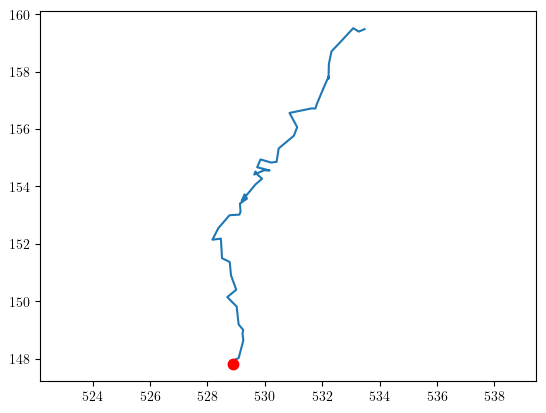

In [13]:
voltage = "4"
number = "4"
length_data = 50

data = np.loadtxt(f"..\\Data\\Trajectories_AC_2d\\{voltage}Vpp\\{voltage}Vpp{number}.txt")[0:length_data,1:]
ys = data-data[0]
plt.figure()
plt.plot(data[:,0],data[:,1],'-')
plt.plot(data[0,0],data[0,1],'r.', markersize=15)
plt.axis("equal");
plt.savefig(f"data_colloid_{voltage}Vpp{number}_length{length_data}.png", dpi=300)

ABM class (small modification to allow for finer discretisation of numerical scheme than what we have in data)


In [14]:
class ABM(rao_blackwell.RBMVLinearGauss):
    def __init__(self, **kwargs):
        default_parameters = {'D0': 1, 'Drot': 1, 'Dobs': 1}
        self.__dict__.update(default_parameters)
        self.__dict__.update(kwargs)
        num_collate_dt = int(dt_data/dt)  # k
        
        A = lambda w: np.array([[1., 0., num_collate_dt*dt*cos(w)],[0., 1., num_collate_dt*dt*sin(w)],[0.,0.,1.]])
        Gamma = lambda w: np.diag([(num_collate_dt*2*dt*self.D0),(num_collate_dt*2*dt*self.D0),0.00001])
        
        H = lambda w: np.array([[1,0,0],[0,1,0]])
        Sigma = lambda w: np.eye(2)*self.Dobs
        m0 = lambda w: np.array([0.,0.,2.])
        cov0 = lambda w: np.diag([5.,5.,1.])
        PW0 = dists.Uniform(0, 2*pi)
        def PW(t, wp):
            return dists.Normal(loc=wp, scale=sqrt(self.Drot))
        rao_blackwell.RBMVLinearGauss.__init__(self,PW0, PW, A, H, Gamma, Sigma, m0, cov0)
        
myRB_nd = ABM()

do inference

In [15]:

prior_dict = {'D0': dists.Gamma(),
      'Drot': dists.Gamma(),
      'Dobs':dists.Gamma(a=1., b=5)}
   
my_prior = dists.StructDist(prior_dict)
my_SMC2 = smp.SMC2(ssm_cls=ABM, prior=my_prior, data=ys, fk_cls=rao_blackwell.Bootstrap_RaoBlackwell, len_chain=15)
my_alg = particles.SMC(fk=my_SMC2, N=300, store_history=True, verbose=100)
my_alg.run()

t=0, ESS=4494.29, Nx=100
t=1, ESS=4021.91, Nx=100
t=2, ESS=572.04, Nx=100
t=3, Metropolis acc. rate (over 14 steps): 0.086, ESS=3554.43, Nx=100
t=4, ESS=2059.96, Nx=100
t=5, Metropolis acc. rate (over 14 steps): 0.082, ESS=3312.38, Nx=100
t=6, ESS=2196.35, Nx=100
t=7, Metropolis acc. rate (over 14 steps): 0.100, ESS=3933.30, Nx=100
t=8, ESS=3557.49, Nx=100
t=9, ESS=3212.04, Nx=100
t=10, ESS=2515.74, Nx=100
t=11, ESS=2136.27, Nx=100
t=12, Metropolis acc. rate (over 14 steps): 0.170, ESS=4310.15, Nx=100
t=13, ESS=4049.88, Nx=100
t=14, ESS=3716.42, Nx=100
t=15, ESS=3084.69, Nx=100
t=16, ESS=3371.80, Nx=100
t=17, ESS=2678.68, Nx=100
t=18, ESS=2548.20, Nx=100
t=19, ESS=3112.88, Nx=100
t=20, ESS=2859.11, Nx=100
t=21, ESS=2897.35, Nx=100
t=22, ESS=2695.99, Nx=100
t=23, ESS=2510.39, Nx=100
t=24, ESS=2423.46, Nx=100
t=25, ESS=2423.53, Nx=100
t=26, ESS=2346.40, Nx=100
t=27, ESS=2240.15, Nx=100
t=28, Metropolis acc. rate (over 14 steps): 0.203, ESS=4300.42, Nx=100
t=29, ESS=4124.47, Nx=100
t=30, 

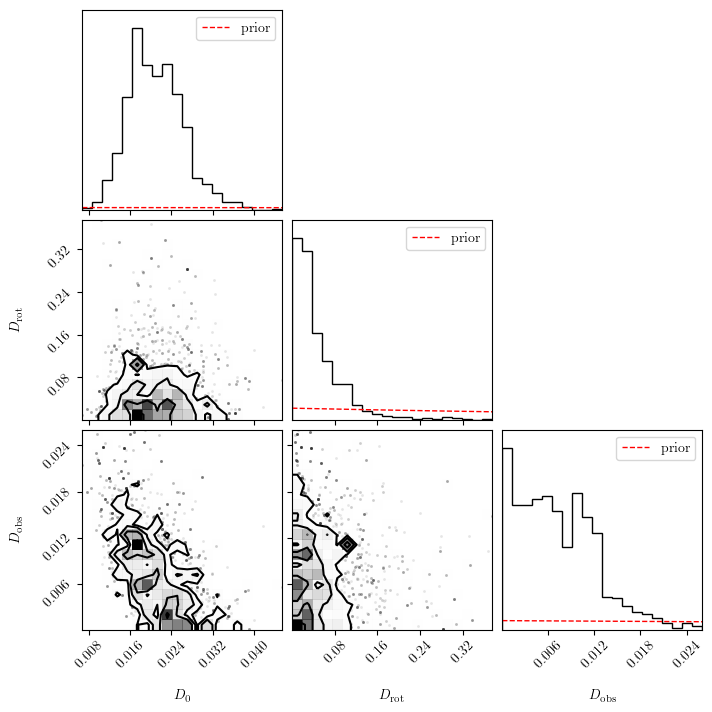

In [16]:
#particles.plotting_util.extended_corner(np.stack([my_alg.X.theta[p] for p in prior_dict.keys()]), prior_dict, my_alg.wgts.W)
particles.plotting_util.extended_corner(np.stack([my_alg.X.theta[p] for p in prior_dict.keys()]), prior_dict, my_alg.wgts.W, param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"])
plt.savefig(f"corner_SMC2_data{length_data}.png", dpi=300)

In [17]:
my_pmmh = mcmc.PMMH(ssm_cls=ABM, fk_cls=rao_blackwell.Bootstrap_RaoBlackwell, prior=my_prior, data=ys, Nx=Nx,  niter=20000, verbose=100)
my_pmmh.run()

Iteration 0, 2025-07-20 23:03:45.880997, D0=0.8460100695298249, Dobs=0.006178190339672836, Drot=2.3827387813850263
Iteration 200, 2025-07-20 23:08:04.119550, acc. rate=0.205, D0=0.007385883366914135, Dobs=0.041032465018997, Drot=0.27771781655791894
Iteration 400, 2025-07-20 23:12:43.699467, acc. rate=0.215, D0=0.022161239975761585, Dobs=0.004630653313502578, Drot=0.06970308966676339
Iteration 600, 2025-07-20 23:16:23.795433, acc. rate=0.190, D0=0.02037241690765258, Dobs=0.0032137070562082144, Drot=0.007999272454736323
Iteration 800, 2025-07-20 23:20:40.363808, acc. rate=0.217, D0=0.027021061973566178, Dobs=0.008162090861125909, Drot=0.00683377872187918
Iteration 1000, 2025-07-20 23:25:13.745593, acc. rate=0.235, D0=0.02123311636053849, Dobs=0.004283996086911866, Drot=0.016196457576202538
Iteration 1200, 2025-07-20 23:29:11.773433, acc. rate=0.243, D0=0.02674609506049816, Dobs=0.002210880154278451, Drot=0.025481807366063713
Iteration 1400, 2025-07-20 23:32:59.645937, acc. rate=0.252, D0

Iteration 12000, 2025-07-21 03:12:32.425214, acc. rate=0.238, D0=0.02336056037820747, Dobs=0.0001671544820756822, Drot=0.008609789542706428
Iteration 12200, 2025-07-21 03:15:48.143344, acc. rate=0.237, D0=0.016660898265713635, Dobs=0.005078257038119923, Drot=0.05966057307787902
Iteration 12400, 2025-07-21 03:20:04.096385, acc. rate=0.237, D0=0.027398290632267053, Dobs=0.001078715638093316, Drot=0.00942881851244547
Iteration 12600, 2025-07-21 03:22:33.840504, acc. rate=0.235, D0=0.023008013274083784, Dobs=0.0012980414922901737, Drot=0.023346354871021206
Iteration 12800, 2025-07-21 03:27:04.269593, acc. rate=0.235, D0=0.021377396841432486, Dobs=0.008063820066316193, Drot=0.04428458140069554
Iteration 13000, 2025-07-21 03:31:07.652484, acc. rate=0.235, D0=0.018779423612143863, Dobs=0.006679332556453732, Drot=0.05159469009285767
Iteration 13200, 2025-07-21 03:35:32.139513, acc. rate=0.235, D0=0.016615613172329943, Dobs=0.01006198650252656, Drot=0.05802403404576135
Iteration 13400, 2025-07-

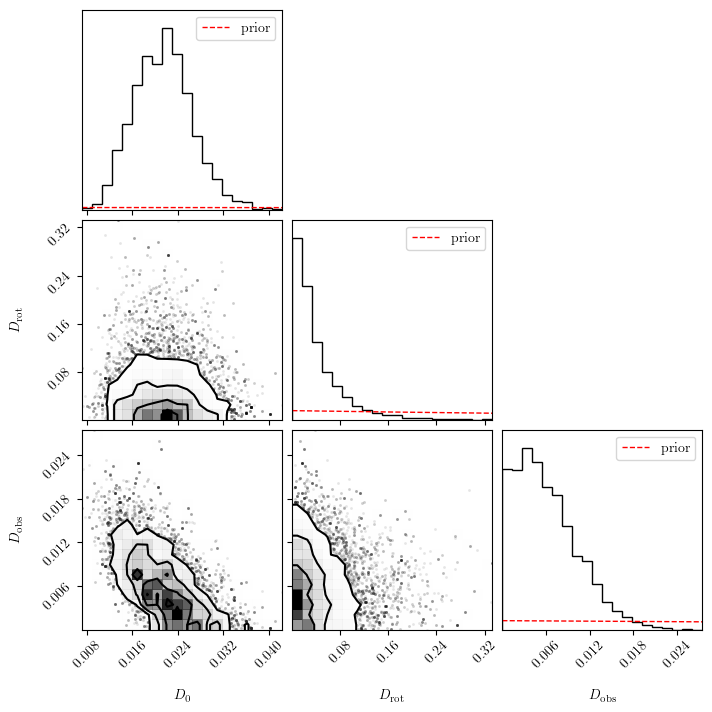

In [18]:

array_samples_PMMH = np.stack([my_pmmh.chain.theta[p] for p in prior_dict.keys()])
N_burnin = 2000
array_samples_burnin = array_samples_PMMH[:,N_burnin:]
plotting_util.extended_corner(array_samples_burnin, prior_dict, param_labels=["$D_0$", "$D_{\\text{rot}}$", "$D_{\\text{obs}}$"])
plt.savefig(f"corner_PMMH_data{length_data}.png", dpi=300)